# DCGAN PyTorch

### Import Libraries

In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import roc_auc_score
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


### Hyperparameters

In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
z_dim = 100

# Number of training epochs
num_epochs = 100

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Loading dataset

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image, ImageEnhance
import io

# Load the dataset from parquet
splits = {'train': 'data/train-00000-of-00001-fa0b6bb53e3b3d16.parquet', 
          'validation': 'data/validation-00000-of-00001-49f45a5ed0b4ad18.parquet', 
          'test': 'data/test-00000-of-00001-48d445de0e368b7c.parquet'}

df = pd.read_parquet("hf://datasets/James-A/Minecraft-16x-Dataset/" + splits["train"])

print("DataFrame shape (before filtering):", df.shape)
print("DataFrame columns:", df.columns.tolist())

df.head()

c:\Users\ASUS\torch-gpu\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataFrame shape (before filtering): (1366, 19)
DataFrame columns: ['image', 'texture_name', 'texture_size', 'type', 'primary_colors', 'secondary_colors', 'pattern_description', 'texture_style', 'lighting_reflection', 'symmetry', 'tileable_direction', 'visual_complexity', 'illumination_effects', 'usage_context', 'functionality', 'related_items_blocks', 'mimicry_biome_association', 'special_effects_in_game_functionality', 'overall_texture_description']


,image,texture_name,texture_size,type,primary_colors,secondary_colors,pattern_description,texture_style,lighting_reflection,symmetry,tileable_direction,visual_complexity,illumination_effects,usage_context,functionality,related_items_blocks,mimicry_biome_association,special_effects_in_game_functionality,overall_texture_description
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Acacia Trapdoor,16x16,"Block - Wood, Utility","Warm Brown (RGB: [169, 92, 51])","Dark Brown (RGB: [101, 56, 31]), Gray (RGB: [6...",The texture displays a warm brown wooden plank...,Pixelated,Uniform Reflection. The simulation of uniforml...,Symmetrical,Tileable both vertically and horizontally,"Low. The design is straightforward, with repet...",None,"Building, decoration, security (can be used as...","Can be opened or closed by players, may intera...","Acacia Door, Acacia Planks, Acacia Slab, Acaci...",Mimics a wooden trapdoor made from acacia wood...,None,A 16x16 pixel art block texture depicting an A...
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Amethyst Cluster,16x16,"Block - Mineral, Decorative","Medium Purple (RGB: [134, 103, 172])","Light Purple (RGB: [189, 160, 221]), Yellow (R...","Sharp, angular crystalline structures reminisc...",Pixelated,Directional Reflection. Brighter highlights on...,Non-symmetrical,Non-tileable,"Medium, with varied geometrical shapes and ref...",None,"Decoration, crafting, light-diffusing block in...",Decorative and can be harvested for Amethyst S...,"Amethyst Shard, Budding Amethyst, Amethyst Blo...",Mimics real-world amethyst crystal clusters an...,None,A 16x16 pixel art block texture displaying an ...
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Ancient Debris Side,16x16,Block - Ore,"Dark Brown (RGB: [74, 44, 42])","Lighter Brown (RGB: [113, 66, 65]), Cream (RGB...",Camouflaged pattern with speckles and streaks ...,Pixelated,Uniform Reflection. The texture displays an ev...,Non-symmetrical,Tileable both vertically and horizontally,"High, due to the intricate camouflaged pattern...",None,"Building, Crafting (used to refine into the hi...","Non-decorative, primarily used in the smelting...","Netherite Block, Netherite Ingot, Netherite Sc...","Mimics an ore-rich rock, specific to the Nethe...","No special visual effects, used in smelting to...",A 16x16 pixel art block texture depicting the ...
3,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",Ancient Debris Top,16x16,Block - Ore,"Dark Brown (RGB: [77, 49, 49])","Medium Brown (RGB: [96, 60, 60]), Light Gray (...",Concentric square and rectangular shapes creat...,Pixelated,Directional Reflection. The texture displays s...,Symmetrical,Tileable both vertically and horizontally,"Medium. The texture has a structured, detailed...",None,"Mining, smithing, building.",Used for crafting high-tier materials and equi...,"Netherite Scrap, Netherite Block, Netherite In...",Mimics a complex mineral-like pattern and is a...,None,A 16x16 pixel art block texture of ancient deb...
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Anvil Base,16x16,"Block - Utility, Metal","Dark Gray (RGB: [54, 54, 54])","Lighter Gray (RGB: [76, 76, 76]), Very Dark Gr...",Variegated gray texture with splotches and spe...,Pixelated with a noise pattern to simulate wea...,Spotted Reflection. The texture includes light...,Non-symmetrical,Non-tileable as it represents a specific part ...,"Medium, due to variations in gray to simulate ...",None,"Crafting, utility, repairing tools and armor.","Provides the functionality to repair items, re...","Anvil, Slightly Damaged Anvil, Very Damaged An...","Mimics the look of a forged metal anvil, not a...",None beyond the crafting and repairing functio...,A 16x16 pixel art block texture representing t...


In [4]:
# Check unique types to understand the data
print("\nSample types:")
print(df['type'].head(20))


Sample types:
0                 Block - Wood, Utility
1           Block - Mineral, Decorative
2                           Block - Ore
3                           Block - Ore
4                Block - Utility, Metal
5                Block - Utility, Metal
6                Block - Utility, Metal
7                Block - Metal, Utility
8                    Block - Decorative
9                    Block - Decorative
10                        Block - Plant
11            Block - Plant, Decorative
12                        Block - Plant
13                        Block - Plant
14                        Block - Plant
15                        Block - Plant
16                Block - Wood, Utility
17    Block - Wood, Decorative, Barrier
18                Block - Wood, Utility
19                        Block - Plant
Name: type, dtype: object


### Function utk extract apa types yang available dalam data kita

In [5]:
# Filter for rows
# df = df[df['type'].str.contains('ore', case=False, na=False)]

# Get all unique types from the 'type' column
def extract_unique_types(df):
    """
    Extract all unique type values from the 'type' column.
    Format: "Block - Type1, Type2, Type3"
    """
    all_types = set()
    
    for type_str in df['type']:
        if pd.isna(type_str):
            continue
        
        # Split by " - " to separate "Block" from the types
        parts = type_str.split(' - ')
        
        if len(parts) > 1:
            # Get the types part (after "Block - ")
            types_part = parts[1]
            
            # Split by comma to get individual types
            individual_types = [t.strip() for t in types_part.split(',')]
            
            # Add to set
            all_types.update(individual_types)
    
    return sorted(list(all_types))

In [6]:
# Extract unique types
unique_types = extract_unique_types(df)

print(f"\nTotal unique types: {len(unique_types)}")
print("\nAll unique types:")
for i, type_name in enumerate(unique_types, 1):
    print(f"{i}. {type_name}")


Total unique types: 165

All unique types:
1. Accessory
2. Agricultural
3. Agriculture
4. Ammunition
5. Apparel
6. Aquatic
7. Aquatic creature
8. Armor
9. Armor Component
10. Armor Trim
11. Armor UI Component
12. Armor Upgrade
13. Armor Upgrade Component
14. Artifact
15. Barrier
16. Bed
17. Bottle
18. Brewing Ingredient
19. Building
20. Building Material
21. Building material
22. Ceramic
23. Clay
24. Clay-Based
25. Cloth
26. Colorant
27. Combat
28. Concrete Powder
29. Construction Material
30. Consumable
31. Container
32. Coral
33. Craft
34. Craftable
35. Crafted Material
36. Crafted Wood
37. Crafting
38. Crafting Component
39. Crafting Ingredient
40. Crafting Material
41. Creature
42. Creature-related
43. Crop
44. Decoration
45. Decorative
46. Decorative Plant
47. Dirt
48. Dye
49. Earth
50. Educational
51. Effect
52. Egg
53. Enchanted
54. End-themed
55. Entertainment
56. Entity
57. Entity Drop
58. Entity Summoner
59. Entity-related
60. Equipment
61. Equippable
62. Explosive
63. Farmi

### Function untuk tgk berapa data points yang ada untuk semua types tu

In [7]:
# Optional: Count frequency of each type
def count_type_frequencies(df):
    """Count how many times each type appears"""
    type_counts = {}
    
    for type_str in df['type']:
        if pd.isna(type_str):
            continue
        
        parts = type_str.split(' - ')
        if len(parts) > 1:
            types_part = parts[1]
            individual_types = [t.strip() for t in types_part.split(',')]
            
            for t in individual_types:
                type_counts[t] = type_counts.get(t, 0) + 1
    
    return type_counts

# Get frequency counts
type_frequencies = count_type_frequencies(df)

In [8]:
print("\n\nType frequencies (sorted by count):")
for type_name, count in sorted(type_frequencies.items(), key=lambda x: x[1], reverse=True):
    print(f"{type_name}: {count}")



Type frequencies (sorted by count):
Utility: 378
Decorative: 255
Wood: 147
Plant: 144
Stone: 126
Potion: 62
Food: 56
Tool: 51
Spawn Egg: 46
Light Source: 39
Building: 33
Metal: 32
Armor: 29
Transparent: 27
Organic: 27
Glass: 26
Redstone: 25
Ore: 23
Artifact: 21
Transportation: 21
Combat: 21
Natural: 20
Furniture: 19
Aquatic: 19
Building Material: 18
Ceramic: 18
Dye: 18
Crop: 17
Mineral: 15
Egg: 15
Consumable: 15
Weapon: 12
Music Disc: 11
Earth: 10
Crafting Material: 10
Brewing Ingredient: 9
Clay: 8
Storage: 8
Soil: 8
Textile: 8
Container: 7
Terra Cotta: 7
Nature: 6
Ice: 6
Powder: 6
Underwater: 5
Crafting Component: 5
Nether: 4
Mechanical: 4
Explosive: 4
Navigation: 4
Decoration: 3
Craftable: 3
Coral: 3
Dirt: 3
Terracotta: 3
Resource: 3
Monster: 3
Mob Drop: 3
Crafting Ingredient: 3
Ammunition: 3
Lighting: 2
Construction Material: 2
Marine: 2
Portal: 2
Precious: 2
Snow: 2
Surface: 2
Building material: 2
Foliage: 2
Rail: 2
Creature: 2
Trap: 2
Gem: 2
Raw Material: 2
Entity Drop: 2
Wearab

### Function to extract desired types

In [9]:
def extract_types_from_row(type_str):
    """Extract individual types from a row's type column"""
    if pd.isna(type_str):
        return []
    
    parts = type_str.split(' - ')
    if len(parts) > 1:
        types_part = parts[1]
        individual_types = [t.strip() for t in types_part.split(',')]
        return individual_types
    return []

def get_primary_label(type_str, priority_types):
    """
    Get the primary label based on priority types.
    Returns the first matching type from priority_types, or None if no match.
    """
    types = extract_types_from_row(type_str)
    
    # Check each priority type in order
    for priority_type in priority_types:
        if priority_type in types:
            return priority_type
    
    return None

### List to Filter

In [10]:
# Define apa yang korang nak sini
filter_types = [
    'Utility',
    'Decorative',
    'Wood',
    'Plant',
    'Stone',
    'Potion',
    'Food',
    'Tool',
    'Spawn Egg',
    'Light Source'
]


In [11]:
# Apply labeling
df['label'] = df['type'].apply(lambda x: get_primary_label(x, filter_types))

# Check results before filtering
print("Label distribution before filtering:")
print(df['label'].value_counts(dropna=False))
print(f"\nRows with no matching label (will be dropped): {df['label'].isna().sum()}")

# Drop rows that don't have any of the top 10 types
df_filtered = df[df['label'].notna()].copy()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"Rows dropped: {len(df) - len(df_filtered)}")

Label distribution before filtering:
label
Utility       378
None          329
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Rows with no matching label (will be dropped): 329

Original dataset size: 1366
Filtered dataset size: 1037
Rows dropped: 329


In [12]:
print("\nFinal label distribution:")
print(df_filtered['label'].value_counts())

# Create numeric labels for training (0-9)
label_to_idx = {label: idx for idx, label in enumerate(filter_types)}
df_filtered['label_idx'] = df_filtered['label'].map(label_to_idx)

print("\nLabel to index mapping:")
for label, idx in label_to_idx.items():
    count = (df_filtered['label'] == label).sum()
    print(f"{idx}: {label} ({count} samples)")

images = df_filtered['image'].tolist()
labels = df_filtered['label_idx'].values

print(f"\nFinal number of images: {len(images)}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")


Final label distribution:
label
Utility       378
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Label to index mapping:
0: Utility (378 samples)
1: Decorative (211 samples)
2: Wood (49 samples)
3: Plant (110 samples)
4: Stone (86 samples)
5: Potion (62 samples)
6: Food (50 samples)
7: Tool (45 samples)
8: Spawn Egg (46 samples)
9: Light Source (0 samples)

Final number of images: 1037
Labels shape: (1037,)
Unique labels: [0 1 2 3 4 5 6 7 8]


### Data augmentation function

sbb data sikit sngt

In [13]:
import torchvision.transforms as transforms

def augment_image(img, apply_augmentation_prob=0.6):
    """
    Apply random augmentations to increase dataset variety
    apply_augmentation_prob: probability of applying ANY augmentation (default 0.9 = 90% chance)
    """
    # Skip augmentation entirely with some probability
    if np.random.rand() > apply_augmentation_prob:
        return img  # Return original image
    
    # Random horizontal flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Random vertical flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Random 90-degree rotations (75% chance)
    if np.random.rand() > 0.25:
        rotation = np.random.choice([0, 90, 180, 270])
        if rotation > 0:
            img = img.rotate(rotation)
    
    # Random brightness adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(np.random.uniform(0.8, 1.2))
    
    # Random contrast adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(np.random.uniform(0.85, 1.15))
    
    return img

# Usage in your loop:
num_augmentations = 3 # <------------------------------------------------ BOLEH ADJUST BRP BANYAK KALI NK AUGMENT SINI

## EVERYTHING DATA PREPROCESS STARTS HERE ⬇️⬇️⬇️⬇️

In [14]:
# Define target size
target_size = (16, 16)

# Process images: resize, convert to RGB
data_list = []
labels_list = []

augment = True # <-------------------------------------------------------- Change False if dont want AUGMENT DATA

for img_data in images:
    # If image is stored as bytes, convert to PIL Image
    if isinstance(img_data, dict) and 'bytes' in img_data:
        img = Image.open(io.BytesIO(img_data['bytes']))
    elif isinstance(img_data, bytes):
        img = Image.open(io.BytesIO(img_data))
    else:
        img = img_data  # Already a PIL Image
    
    # Resize if needed
    if img.size != target_size:
        img = img.resize(target_size, Image.NEAREST)
    
    # Convert RGBA to RGB (handle transparency)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        img = img.convert('RGB')

    data_list.append(np.array(img))
    labels_list.append(labels[idx])

    if augment:
        for _ in range(num_augmentations - 1): # <------------------------------------------------ DATA AUGMENTATION HERE
            aug_img = augment_image(img.copy())
            data_list.append(np.array(aug_img))
            labels_list.append(labels[idx])

# Convert to numpy array
data = np.array(data_list)
labels = np.array(labels_list) 
print("Shape: ", data.shape)

# Create dummy labels (same as original dataset structure)
# labels = np.zeros(len(images)) 

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

# --- NORMALIZATION FOR DCGAN ---

# If values are 0..255, convert to 0..1
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0

# Convert 0..1 -> -1..1 (MATCH Tanh output)
images_tensor = images_tensor * 2.0 - 1.0

# Create dataset and loader
dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)
print(f"Total batches: {len(loader)}")
print(f"Images tensor shape: {images_tensor.shape}")
print(f"Images tensor range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

Shape:  (3111, 16, 16, 3)
Shape (before permute):  torch.Size([3111, 16, 16, 3])
Shape (after permute):  torch.Size([3111, 3, 16, 16])
Device:  cuda:0
Total batches: 49
Images tensor shape: torch.Size([3111, 3, 16, 16])
Images tensor range: [-1.00, 1.00]


c:\Users\ASUS\torch-gpu\.venv\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([64, 3, 16, 16]) torch.Size([64])


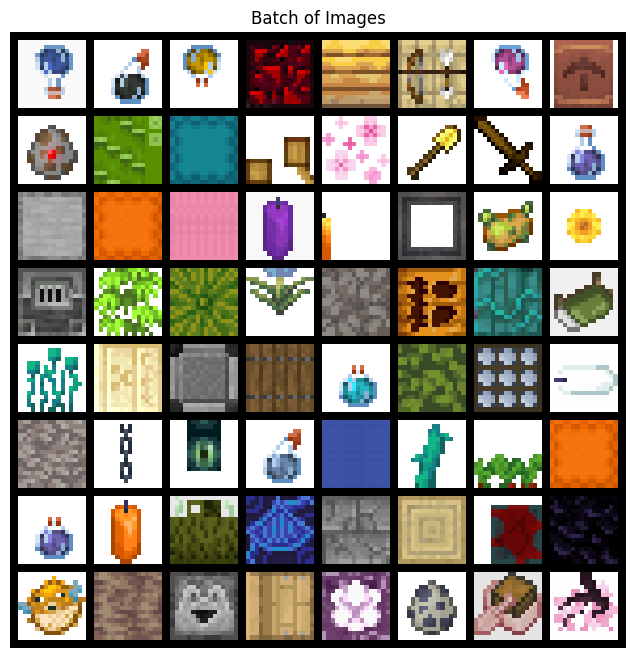

In [16]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

### Weights initialization

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0)

### Generator

In [18]:

# Size of feature maps in generator
ngf = 32

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.gen = nn.Sequential(
            # LAYER 1: The "Foundation" Layer
            # Input: (z_dim) x 1 x 1
            # Output: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(
                in_channels = z_dim,
                out_channels = ngf * 8,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(inplace = True),
            
            # LAYER 2: First Upsample
            # Input: (ngf * 8) x 4 x 4
            # Output: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels = ngf * 8,
                out_channels = ngf * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(inplace = True),
            
            # LAYER 3: Final Upsample to 16x16 Sprite
            # Input: (ngf * 4) x 8 x 8
            # Output: (nc) x 16 x 16
            nn.ConvTranspose2d(
                in_channels = ngf * 4,
                out_channels = nc,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)


In [19]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


### Discriminator

In [20]:
# Size of feature maps in discriminator
ndf = 32

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            # --- LAYER 1: THE INPUT LAYER ---
            # Input: (nc) x 16 x 16
            # Output: (ndf) x 8 x 8
            nn.Conv2d(
                in_channels  = nc,
                out_channels = ndf,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            # Note: No BatchNorm in the first layer of the Discriminator (DCGAN rule)
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 2: THE COMPRESSION LAYER ---
            # Input: (ndf) x 8 x 8
            # Output: (ndf * 2) x 4 x 4
            nn.Conv2d(
                in_channels  = ndf,
                out_channels = ndf * 2,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            nn.BatchNorm2d(num_features = ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 3: THE CLASSIFICATION LAYER ---
            # Input: (ndf * 2) x 4 x 4
            # Output: 1 x 1 x 1 (A single probability score)
            nn.Conv2d(
                in_channels  = ndf * 2,
                out_channels = 1,
                kernel_size  = 4,
                stride       = 1, # No more downsampling
                padding      = 0,
                bias         = False
            ),
            nn.Sigmoid() # Outputs a value between 0 (Fake) and 1 (Real)
        )

    def forward(self, x):
        return self.disc(x)

In [21]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


### Loss Function and Optimizers

In [22]:
# Learning rate for optimizers
lrD = 5e-3
lrG = 7e-3

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))

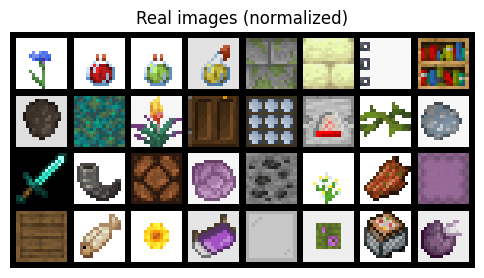

In [23]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

real_images, _ = next(iter(loader))   # unpack (images, labels)
grid = vutils.make_grid(real_images[:32], normalize=True, padding=2)


plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Real images (normalized)")
plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
plt.show()


In [24]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/49]	Loss_D: 1.4754	Loss_G: 3.7539	D(x): 0.4418	D(G(z)): 0.4621 / 0.0249
[1/100][0/49]	Loss_D: 1.6777	Loss_G: 1.5089	D(x): 0.5595	D(G(z)): 0.5820 / 0.2689
[2/100][0/49]	Loss_D: 1.9748	Loss_G: 1.2857	D(x): 0.5562	D(G(z)): 0.6435 / 0.3113
[3/100][0/49]	Loss_D: 1.4939	Loss_G: 0.9095	D(x): 0.5624	D(G(z)): 0.5639 / 0.4255
[4/100][0/49]	Loss_D: 1.1367	Loss_G: 1.2131	D(x): 0.6252	D(G(z)): 0.4486 / 0.3081
[5/100][0/49]	Loss_D: 1.2216	Loss_G: 0.9470	D(x): 0.6204	D(G(z)): 0.4573 / 0.4110
[6/100][0/49]	Loss_D: 1.2814	Loss_G: 1.1594	D(x): 0.4862	D(G(z)): 0.3740 / 0.3414
[7/100][0/49]	Loss_D: 1.2873	Loss_G: 1.0102	D(x): 0.5212	D(G(z)): 0.4446 / 0.3708
[8/100][0/49]	Loss_D: 1.3563	Loss_G: 1.1008	D(x): 0.5356	D(G(z)): 0.4848 / 0.3472
[9/100][0/49]	Loss_D: 1.3862	Loss_G: 1.3495	D(x): 0.5299	D(G(z)): 0.4790 / 0.2872
[10/100][0/49]	Loss_D: 1.3445	Loss_G: 1.0287	D(x): 0.4830	D(G(z)): 0.4389 / 0.3687
[11/100][0/49]	Loss_D: 1.6975	Loss_G: 1.2251	D(x): 0.4756	D(G(z)): 0.56

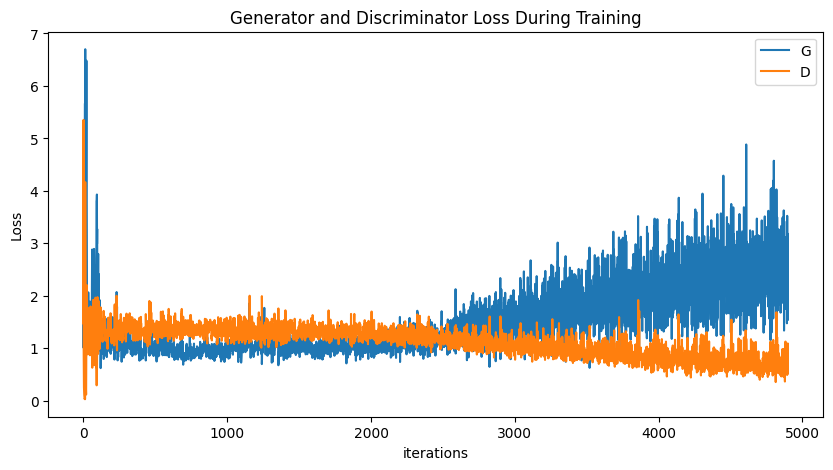

In [25]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

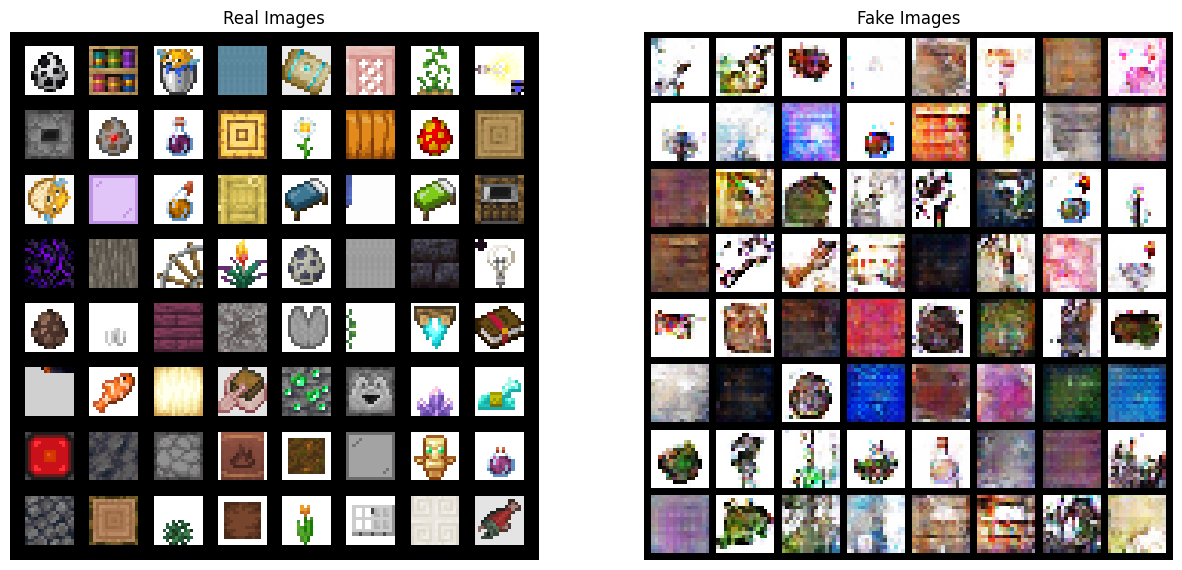

In [26]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

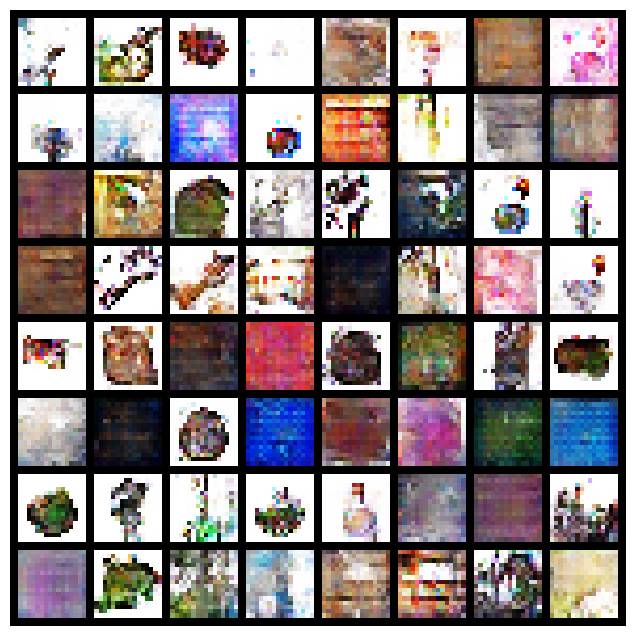

In [27]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# EVALUATION 

In [28]:
imgs_real, y = next(iter(loader))
print(imgs_real.shape, imgs_real.min().item(), imgs_real.max().item())

torch.Size([64, 3, 16, 16]) -1.0 1.0


In [29]:
torch.manual_seed(42)

N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train

eval_train_set, eval_test_set = random_split(dataset, [n_train, n_test])


eval_train_loader = DataLoader(eval_train_set, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
eval_test_loader  = DataLoader(eval_test_set,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("Train/Test:", len(eval_train_set), len(eval_test_set))
print("Train/Test:", (len(eval_train_set)/(len(eval_train_set)+len(eval_test_set))), (len(eval_test_loader))/(len(eval_test_loader)+len(eval_train_loader)))


Train/Test: 2488 623
Train/Test: 0.7997428479588556 0.20408163265306123


In [30]:
torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train

eval_train_set, eval_test_set = random_split(dataset, [n_train, n_test], generator=g)

eval_train_loader = DataLoader(eval_train_set, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
eval_test_loader  = DataLoader(eval_test_set,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("Train/Test:", len(eval_train_set), len(eval_test_set))
print("Ratio:", len(eval_train_set)/N, len(eval_test_set)/N)

Train/Test: 2488 623
Ratio: 0.7997428479588556 0.20025715204114433


In [ ]:
netD.eval()
for p in netD.parameters():
    p.requires_grad = False

@torch.no_grad()
def get_scores_real(loader):
    scores, labels = [], []
    for imgs, y in loader:
        imgs = imgs.to(device)

        s = netD(imgs)
        s = s.view(s.size(0), -1).mean(dim=1)  # (N,)
        scores.append(s.cpu().numpy())
        labels.append(y.cpu().numpy())
    return np.concatenate(scores), np.concatenate(labels)

@torch.no_grad()
def get_scores_fake(netG, n_samples, batch_size=128, nz=z_dim):
    scores = []
    netG.eval()
    for i in range(0, n_samples, batch_size):
        cur = min(batch_size, n_samples - i)
        z = torch.randn(cur, nz, 1, 1, device=device)
        fake = netG(z)
        s = netD(fake)
        s = s.view(s.size(0), -1).mean(dim=1)
        scores.append(s.cpu().numpy())
    return np.concatenate(scores)

real_scores, real_labels = get_scores_real(eval_test_loader)
fake_scores = get_scores_fake(netG, n_samples=len(real_scores), batch_size=batch_size, nz=z_dim)

print(real_scores.shape, fake_scores.shape)
print("Real mean/std:", real_scores.mean(), real_scores.std())
print("Fake mean/std:", fake_scores.mean(), fake_scores.std())


RuntimeError: Given transposed=1, weight of size [100, 256, 4, 4], expected input[64, 64, 1, 1] to have 100 channels, but got 64 channels instead

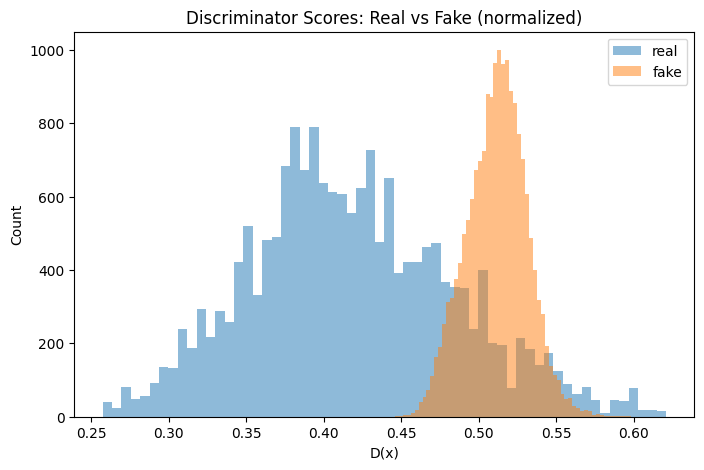

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(real_scores, bins=60, alpha=0.5, label="real")
plt.hist(fake_scores, bins=60, alpha=0.5, label="fake")
plt.title("Discriminator Scores: Real vs Fake (normalized)")
plt.xlabel("D(x)")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    sa, sb = a.var(ddof=1), b.var(ddof=1)
    s = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na+nb-2))
    return (a.mean() - b.mean()) / (s + 1e-12)

print("Real mean/std:", real_scores.mean(), real_scores.std())
print("Fake mean/std:", fake_scores.mean(), fake_scores.std())
print("Cohen's d (real - fake):", cohens_d(real_scores, fake_scores))


Real mean/std: 0.41841477 0.06664003
Fake mean/std: 0.51153743 0.019294512
Cohen's d (real - fake): -1.8982025


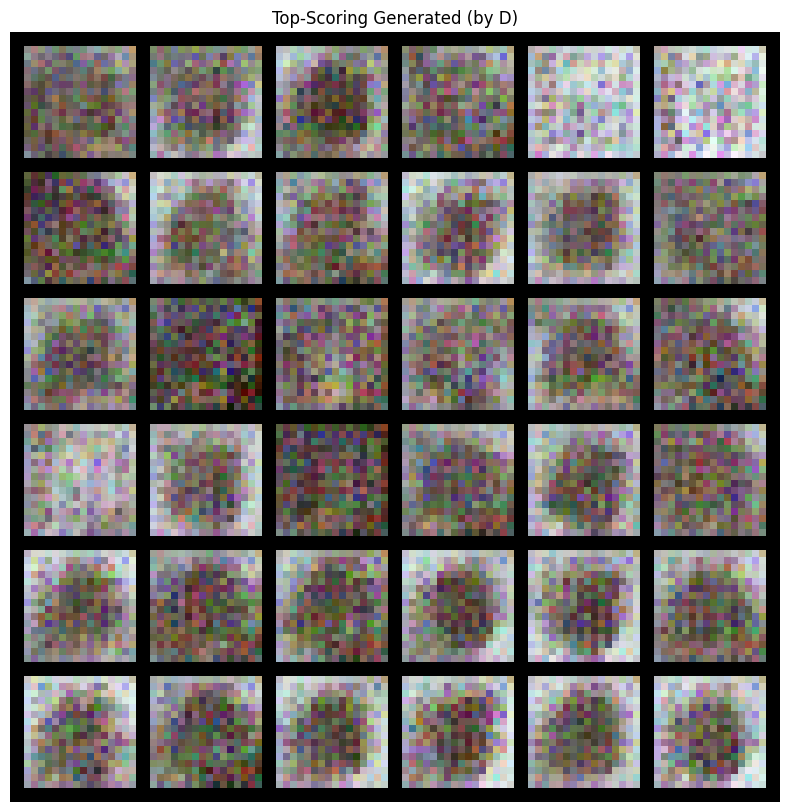

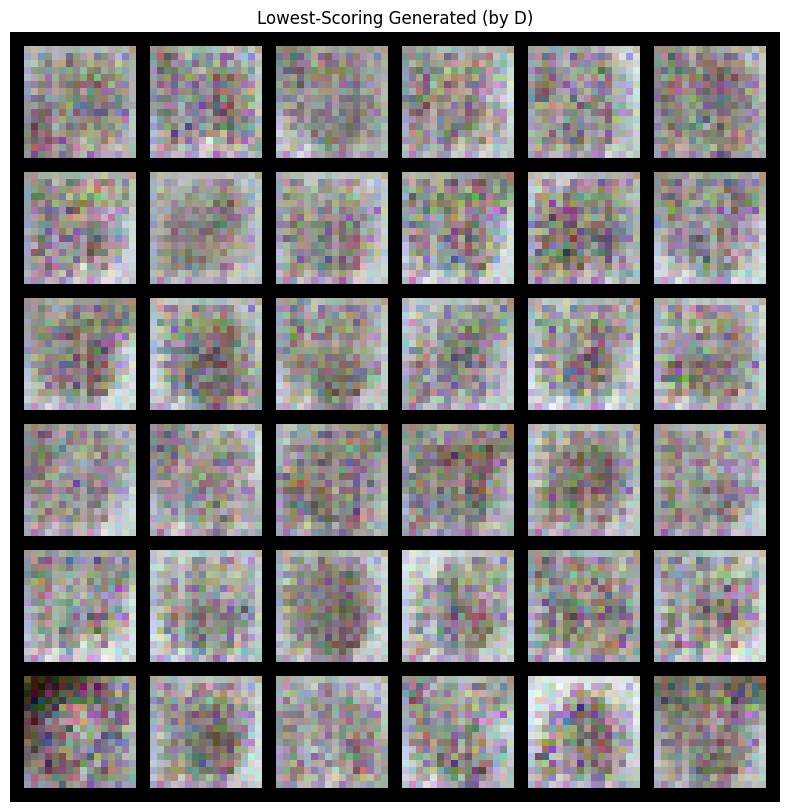

Best score range: 0.53601867 to 0.578229
Worst score range: 0.458451 to 0.48548713


In [ ]:
@torch.no_grad()
def sample_fake_with_scores(netG, n=512, nz=64):
    z = torch.randn(n, nz, 1, 1, device=device)
    fake = netG(z)
    s = netD(fake).view(n, -1).mean(dim=1).cpu().numpy()
    return fake.cpu(), s

fake_imgs, fake_s = sample_fake_with_scores(netG, n=512, nz=64)

best_idx  = np.argsort(fake_s)[-36:]
worst_idx = np.argsort(fake_s)[:36]

grid_best  = vutils.make_grid(fake_imgs[best_idx],  nrow=6, normalize=True)
grid_worst = vutils.make_grid(fake_imgs[worst_idx], nrow=6, normalize=True)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid_best.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Top-Scoring Generated (by D)")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid_worst.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Lowest-Scoring Generated (by D)")
plt.show()

print("Best score range:", fake_s[best_idx].min(), "to", fake_s[best_idx].max())
print("Worst score range:", fake_s[worst_idx].min(), "to", fake_s[worst_idx].max())
